In [2]:
import gzip
from Bio import SeqIO, SeqRecord
from Bio.SeqUtils import CodonAdaptationIndex
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import entropy
import numpy as np
import re
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from datetime import datetime
import random
from collections import Counter

human_proteome_path = "../../datasets/raw/Homo_sapiens.GRCh38.cds.all.fa.gz"
# base_path = "../../datasets/raw/spikenuc0415_clean_n_X.fasta"
# base_path = "../../datasets/raw/spike_nuc_clean_3813"
base_path = "../../datasets/test.fasta"
de_novo_path = "../../sample_outputs/final_full/rnaformerS_large__generated__de_novo.fasta"
de_novo_human_path = "../../sample_outputs/final_full/rnaformerS_large_human_cai__generated__de_novo.fasta"
de_novo_covid_path = "../../sample_outputs/final_full/rnaformerS_large_covid_cai__generated__de_novo.fasta"

covid_3813_path = "../../datasets/test.fasta"
paths = []

pattern = re.compile("[^AatTgGcC*?]")

for i in range(0, 15):
    path = base_path.replace("X", str(i+1))
    paths.append(path)

def is_gene_valid(seq):
    if len(seq) % 3 != 0:
        return False
    if re.search(pattern, str(seq)):
        return False
    
    return True

CODON_INDICES = {
    "AAA": 0,
    "AAC": 1,
    "AAG": 2,
    "AAT": 3,

    "ACA": 4,
    "ACC": 5,
    "ACG": 6,
    "ACT": 7,
 
    "AGA": 8,
    "AGC": 9,
    "AGG": 10,
    "AGT": 11,
 
    "ATA": 12,
    "ATC": 13,
    "ATG": 14,
    "ATT": 15,
 
    "CAA": 16,
    "CAC": 17,
    "CAG": 18,
    "CAT": 19,

    "CCA": 20,
    "CCC": 21,
    "CCG": 22,
    "CCT": 23,
 
    "CGA": 24,
    "CGC": 25,
    "CGG": 26,
    "CGT": 27,
 
    "CTA": 28,
    "CTC": 29,
    "CTG": 30,
    "CTT": 31,

    "GAA": 32,
    "GAC": 33,
    "GAG": 34,
    "GAT": 35,

    "GCA": 36,
    "GCC": 37,
    "GCG": 38,
    "GCT": 39,
 
    "GGA": 40,
    "GGC": 41,
    "GGG": 42,
    "GGT": 43,
 
    "GTA": 44,
    "GTC": 45,
    "GTG": 46,
    "GTT": 47,

    "TAA": 48,
    "TAC": 49,
    "TAG": 50,
    "TAT": 51,

    "TCA": 52,
    "TCC": 53,
    "TCG": 54,
    "TCT": 55,
 
    "TGA": 56,
    "TGC": 57,
    "TGG": 58,
    "TGT": 59,
 
    "TTA": 60,
    "TTC": 61,
    "TTG": 62,
    "TTT": 63,
}

output_data_path_dummy = "../../datasets/correct_dummy.fasta"
output_data_path_covid = "../../datasets/correct_covid.fasta"
output_data_path_human = "../../datasets/correct_human.fasta"

output_data_path_dummy_protein = "../../datasets/correct_dummy_protein.fasta"
output_data_path_covid_protein = "../../datasets/correct_covid_protein.fasta"
output_data_path_human_protein = "../../datasets/correct_human_protein.fasta"

In [19]:
# Synthetic sequences
TAGs = 0
TAAs = 0
TGAs = 0

lastTAGs = 0
lastTAAs = 0
lastTGAs = 0

j = 0
de_novo_seqs_file = SeqIO.parse(covid_3813_path, "fasta")
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq):
        j+=1
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]
        triplets = triplets[0:len(triplets)-1]

        TAGs += triplets.count("TAG")
        TAAs += triplets.count("TAA")
        TGAs += triplets.count("TGA")
        

        if triplets[len(triplets)-1] == 'TAG':
            lastTAGs += 1
        if triplets[len(triplets)-1] == 'TAA':
            lastTAAs += 1
        if triplets[len(triplets)-1] == 'TGA':
            lastTGAs += 1

print(j)

print(TGAs)
print(TAAs)
print(TAGs)

print(lastTAGs)
print(lastTAAs)
print(lastTGAs)

33198it [00:53, 617.25it/s]

33198
573
824
746
0
0
0


In [4]:
# Synthetic sequences
correct_codon_de_novo = 0
de_novo_seqs = []
de_novo_seqs_file = SeqIO.parse(de_novo_path, "fasta")
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if not 'TAG' in triplets[0 : len(triplets)-1] and not 'TAA' in triplets[0 : len(triplets)-1] and not 'TGA' in triplets[0 : len(triplets)-1]:
            # if triplets[len(triplets)-1] == 'TAG' or triplets[len(triplets)-1] == 'TAA' or triplets[len(triplets)-1] == 'TGA':
                correct_codon_de_novo += 1
                de_novo_seqs.append(seq_record)

print("Number of sequences with correct stopcodons (RNAformer-dummy)")
print(100-correct_codon_de_novo/33000*100)
# with open(output_data_path_dummy,'w') as f:
#     SeqIO.write(de_novo_seqs, f, "fasta")

correct_codon_de_novo_covd = 0
de_novo_seqs_covid = []
de_novo_cai_human_seqs_file = SeqIO.parse(de_novo_covid_path, "fasta")
for seq_record in tqdm(de_novo_cai_human_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if not 'TAG' in triplets[0 : len(triplets)-1] and not 'TAA' in triplets[0 : len(triplets)-1] and not 'TGA' in triplets[0 : len(triplets)-1]:
            # if triplets[len(triplets)-1] == 'TAG' or triplets[len(triplets)-1] == 'TAA' or triplets[len(triplets)-1] == 'TGA':
                correct_codon_de_novo_covd += 1
                de_novo_seqs_covid.append(seq_record)

print("Number of sequences with correct stopcodons (RNAformer-CAI-covid)")
print(100-correct_codon_de_novo_covd/33000*100)
# with open(output_data_path_covid,'w') as f:
#     SeqIO.write(de_novo_seqs_covid, f, "fasta")

correct_codon_de_novo_human = 0
de_novo_seqs_human = []
de_novo_cai_covid_seqs_file = SeqIO.parse(de_novo_human_path, "fasta")
for seq_record in tqdm(de_novo_cai_covid_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if not 'TAG' in triplets[0 : len(triplets)-1] and not 'TAA' in triplets[0 : len(triplets)-1] and not 'TGA' in triplets[0 : len(triplets)-1]:
            # if triplets[len(triplets)-1] == 'TAG' or triplets[len(triplets)-1] == 'TAA' or triplets[len(triplets)-1] == 'TGA':
                correct_codon_de_novo_human += 1
                de_novo_seqs_human.append(seq_record)


print("Number of sequences with correct stopcodons (RNAformer-CAI-human)")
print(100-correct_codon_de_novo_human/33000*100)
# with open(output_data_path_human,'w') as f:
#     SeqIO.write(de_novo_seqs_human, f, "fasta")

33001it [00:32, 1012.74it/s]


Number of sequences with correct stopcodons (RNAformer-dummy)
89.99090909090908


33000it [00:32, 1031.24it/s]


Number of sequences with correct stopcodons (RNAformer-CAI-covid)
92.26969696969697


33002it [00:29, 1120.30it/s]

Number of sequences with correct stopcodons (RNAformer-CAI-human)
99.63939393939394


In [1]:
out = []
for record in SeqIO.parse(output_data_path_human, "fasta"):
    if is_gene_valid(record.seq):
        print(record.seq)
        record_out = record
        record_out.seq = record.seq.translate(to_stop=False)
        out.append(record_out)
        

print(out)

# valid = set(valid)
with open(output_data_path_human_protein,'w') as f:
    SeqIO.write(out, f, "fasta")

out = []
for record in SeqIO.parse(output_data_path_covid, "fasta"):
    if is_gene_valid(record.seq):
        print(record.seq)
        record_out = record
        record_out.seq = record.seq.translate(to_stop=False)
        out.append(record_out)
        

print(out)

# valid = set(valid)
with open(output_data_path_covid_protein,'w') as f:
    SeqIO.write(out, f, "fasta")

out = []
for record in SeqIO.parse(output_data_path_dummy, "fasta"):
    if is_gene_valid(record.seq):
        print(record.seq)
        record_out = record
        record_out.seq = record.seq.translate(to_stop=False)
        out.append(record_out)
        

print(out)

# valid = set(valid)
with open(output_data_path_dummy_protein,'w') as f:
    SeqIO.write(out, f, "fasta")

NameError: name 'SeqIO' is not defined

100it [00:10,  9.69it/s]


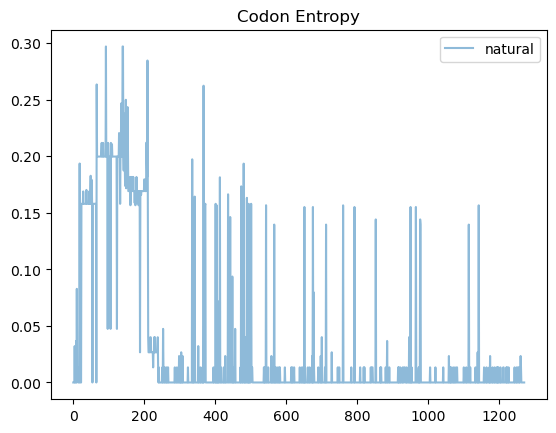

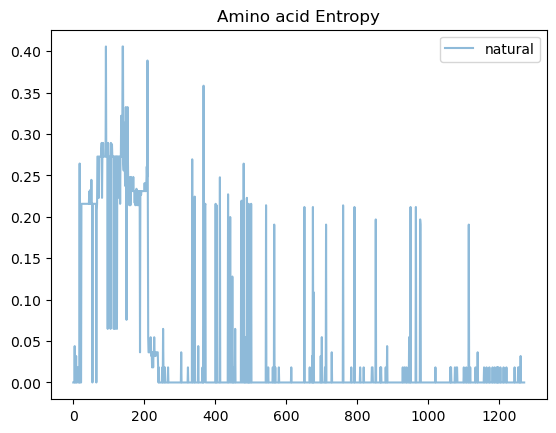

In [3]:
covid_seqs_file = SeqIO.parse(covid_3813_path, "fasta")
covid_df = pd.DataFrame(columns=range(0,1271))
covid_protein_df = pd.DataFrame(columns=range(0,1271))
i = 0
for seq_record in tqdm(covid_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]
        covid_df.loc[len(covid_df)] = triplets
        covid_protein_df.loc[len(covid_df)] = [*seq_record.seq.translate(to_stop=False)]
        i += 1
        if i > 100:
            break


covid_df = covid_df.transpose()
entropies = []
# print(covid_df)
for _, row in covid_df.iterrows():
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 64)
    entropies.append(e)

plt.plot(range(0,1271), entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Codon Entropy")
plt.show()

covid_protein_df = covid_protein_df.transpose()
protein_entropies = []
# print(covid_protein_df)
for _, row in covid_protein_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)

    # print(counts)
    e = entropy(counts, base = 21)
    protein_entropies.append(e)

plt.plot(range(0,1271), protein_entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Amino acid Entropy")
plt.show()



2551it [05:54,  7.20it/s]


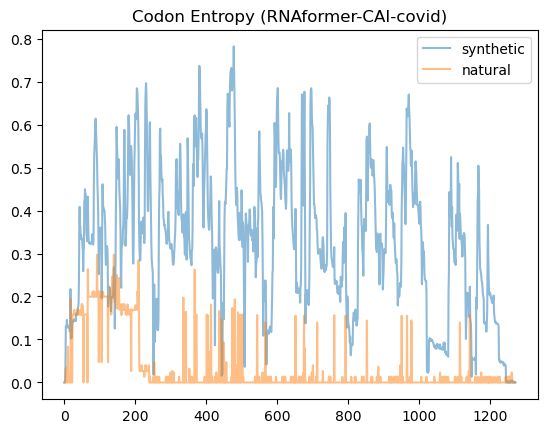

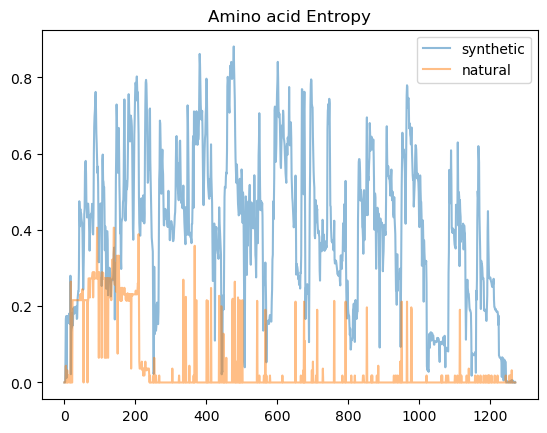

In [4]:
de_novo_cai_covid_seqs_file = SeqIO.parse(output_data_path_covid, "fasta")
de_novo_cai_covid_df = pd.DataFrame(columns=range(0,1271))
de_novo_cai_covid_protein_df = pd.DataFrame(columns=range(0,1271))
i = 0
for seq_record in tqdm(de_novo_cai_covid_seqs_file):
    if is_gene_valid(seq_record.seq) and len(seq_record.seq) == 3813:
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]
        de_novo_cai_covid_df.loc[len(de_novo_cai_covid_df)] = triplets
        de_novo_cai_covid_protein_df.loc[len(de_novo_cai_covid_df)] = [*seq_record.seq.translate(to_stop=False)]
        i += 1
        # if i > 100:
        #     break


de_novo_cai_covid_df = de_novo_cai_covid_df.transpose()
de_novo_cai_covid_entropies = []
# print(de_novo_cai_covid_df)
for _, row in de_novo_cai_covid_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 64)
    de_novo_cai_covid_entropies.append(e)

plt.plot(range(0,1271), de_novo_cai_covid_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Codon Entropy (RNAformer-CAI-covid)")
plt.show()
# covid_entropy = entropy(covid_df)
# print(covid_entropy)

de_novo_cai_covid_protein_df = de_novo_cai_covid_protein_df.transpose()
de_novo_cai_covid_protein_entropies = []
# print(de_novo_protein_df)
for _, row in de_novo_cai_covid_protein_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 21)
    de_novo_cai_covid_protein_entropies.append(e)

plt.plot(range(0,1271), de_novo_cai_covid_protein_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), protein_entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Amino acid Entropy")
plt.show()

116it [00:12,  9.57it/s]


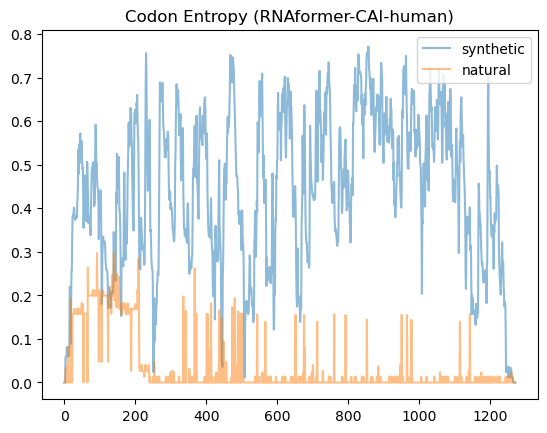

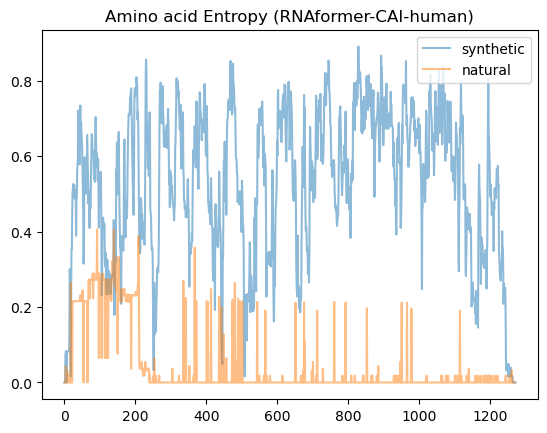

In [5]:
de_novo_cai_human_seqs_file = SeqIO.parse(output_data_path_human, "fasta")
de_novo_cai_human_df = pd.DataFrame(columns=range(0,1271))
de_novo_cai_human_protein_df = pd.DataFrame(columns=range(0,1271))
i = 0
for seq_record in tqdm(de_novo_cai_human_seqs_file):
    if is_gene_valid(seq_record.seq) and len(seq_record.seq) == 3813:
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]
        de_novo_cai_human_df.loc[len(de_novo_cai_human_df)] = triplets
        de_novo_cai_human_protein_df.loc[len(de_novo_cai_human_df)] = [*seq_record.seq.translate(to_stop=False)]
        i += 1
        # if i > 100:
        #     break


de_novo_cai_human_df = de_novo_cai_human_df.transpose()
de_novo_cai_human_entropies = []
# print(de_novo_cai_covid_df)
for _, row in de_novo_cai_human_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 64)
    de_novo_cai_human_entropies.append(e)

plt.plot(range(0,1271), de_novo_cai_human_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Codon Entropy (RNAformer-CAI-human)")
plt.show()
# covid_entropy = entropy(covid_df)
# print(covid_entropy)

de_novo_cai_human_protein_df = de_novo_cai_human_protein_df.transpose()
de_novo_cai_human_protein_entropies = []
# print(de_novo_protein_df)
for _, row in de_novo_cai_human_protein_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 21)
    de_novo_cai_human_protein_entropies.append(e)

plt.plot(range(0,1271), de_novo_cai_human_protein_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), protein_entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Amino acid Entropy (RNAformer-CAI-human)")
plt.show()

3296it [08:12,  6.69it/s]


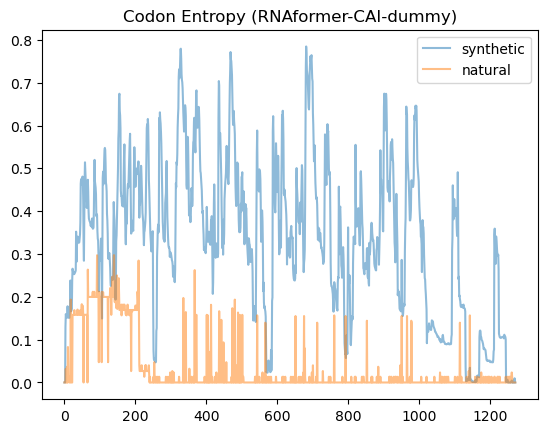

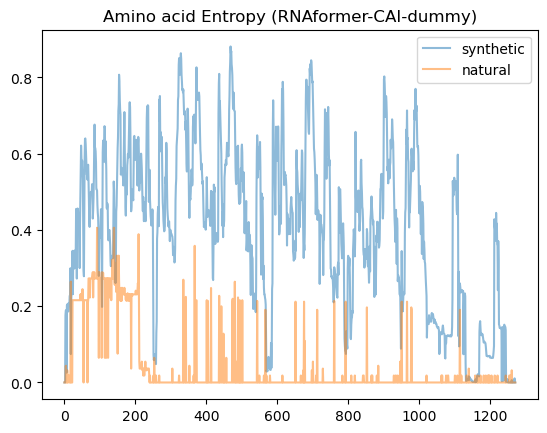

In [6]:
de_novo_cai_dummy_seqs_file = SeqIO.parse(output_data_path_dummy, "fasta")
de_novo_cai_dummy_df = pd.DataFrame(columns=range(0,1271))
de_novo_cai_dummy_protein_df = pd.DataFrame(columns=range(0,1271))
i = 0
for seq_record in tqdm(de_novo_cai_dummy_seqs_file):
    if is_gene_valid(seq_record.seq) and len(seq_record.seq) == 3813:
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]
        de_novo_cai_dummy_df.loc[len(de_novo_cai_dummy_df)] = triplets
        de_novo_cai_dummy_protein_df.loc[len(de_novo_cai_dummy_df)] = [*seq_record.seq.translate(to_stop=False)]
        i += 1
        # if i > 100:
        #     break


de_novo_cai_dummy_df = de_novo_cai_dummy_df.transpose()
de_novo_cai_dummy_entropies = []
# print(de_novo_cai_covid_df)
for _, row in de_novo_cai_dummy_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 64)
    de_novo_cai_dummy_entropies.append(e)

plt.plot(range(0,1271), de_novo_cai_dummy_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Codon Entropy (RNAformer-CAI-dummy)")
plt.show()
# covid_entropy = entropy(covid_df)
# print(covid_entropy)

de_novo_cai_dummy_protein_df = de_novo_cai_dummy_protein_df.transpose()
de_novo_cai_dummy_protein_entropies = []
# print(de_novo_protein_df)
for _, row in de_novo_cai_dummy_protein_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 21)
    de_novo_cai_dummy_protein_entropies.append(e)

plt.plot(range(0,1271), de_novo_cai_dummy_protein_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), protein_entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Amino acid Entropy (RNAformer-CAI-dummy)")
plt.show()